# Import packages

In [1]:
import os
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib import cm
import contextily as cx
import rasterio as rio
from rasterio import features
import rioxarray as rxr
from bmi_topography import Topography
import pyflwdir
from pyflwdir import gis_utils as gis
import numpy as np
from rasterio.features import shapes
from whitebox.whitebox_tools import WhiteboxTools
from shapely.geometry import shape, Point

In [4]:
root = '/Users/aprida/Desktop'

In [19]:
# convenience method for vectorizing a raster
def vectorize(data, nodata, transform, crs=4326, name="value"):
    feats_gen = features.shapes(
        data,
        mask=data != nodata,
        transform=transform,
        connectivity=8,
    )
    feats = [
        {"geometry": geom, "properties": {name: val}} for geom, val in list(feats_gen)
    ]

    # parse to geopandas for plotting / writing to file
    gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
    gdf[name] = gdf[name].astype(data.dtype)
    return gdf

# Define AOI

Text(0.5, 1.0, 'Area Of Interest')

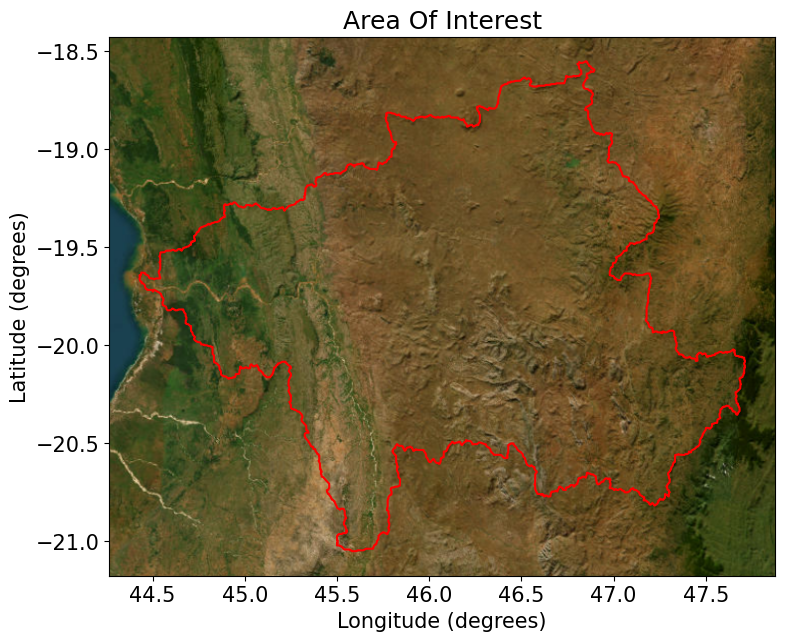

In [8]:
fn = '/Users/aprida/Documents/Consulting/Public_sector/GRMA_Madagascar/fluvialflood/basins/hybas_as_lev05_v1c_mdg.gpkg'
gdf_aoi = gpd.read_file(fn)
gdf_aoi = gdf_aoi[gdf_aoi['gid']==654]
bb_aoi_shp = gpd.GeoDataFrame(geometry=[box(*gdf_aoi.total_bounds)]).buffer(0.05, join_style=2)
bb_aoi_bounds = bb_aoi_shp.bounds

plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(figsize=(10,7))
gdf_aoi.boundary.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('Area Of Interest')

# Static inputs

## Topography

In [79]:
# # Extract DEM
topography_path = f'{root}/topography'
os.makedirs(topography_path, exist_ok=True)
params = Topography.DEFAULT.copy()
params["dem_type"] = "COP30"
params["south"] = bb_aoi_bounds['miny'][0]
params["north"] = bb_aoi_bounds['maxy'][0]
params["west"] = bb_aoi_bounds['minx'][0]
params["east"] = bb_aoi_bounds['maxx'][0]
params["cache_dir"] = root
params["api_key"] = '81bdf4c350b827dee8f69920fa5d63d1'
dem = Topography(**params)
elevtn_raster_path = f'{topography_path}/elevtn.tif'
dem.load().rio.to_raster(elevtn_raster_path) # DEMs downloaded at root directory
elevtn_raster = rxr.open_rasterio(elevtn_raster_path)
attr_new = {'_FillValue':-9999.0} # Add NoData value
elevtn_raster.attrs.update(attr_new)
elevtn_raster = elevtn_raster.rio.clip(gdf_aoi.geometry,
                                 gdf_aoi.crs, 
                                 drop=True)
elevtn_raster.rio.to_raster(elevtn_raster_path)

In [80]:
# Flow Direction

with rio.open(elevtn_raster_path, "r") as src:
    elevtn = src.read(1)
    nodata = src.nodata
    transform = src.transform
    crs = src.crs
    extent = np.array(src.bounds)[[0, 2, 1, 3]]
    latlon = src.crs.is_geographic
    prof = src.profile
    
flw = pyflwdir.from_dem(
    data=elevtn,
    nodata=src.nodata,
    transform=transform,
    latlon=latlon
)

d8_data = flw.to_array(ftype="d8")
prof.update(dtype=d8_data.dtype, nodata=247)

flwdir_raster_path = f'{topography_path}/flwdir.tif'
with rio.open(flwdir_raster_path, "w", **prof) as src:
    src.write(d8_data, 1)

# Upstream area

uparea = flw.upstream_area("km2")
prof.update(dtype=uparea.dtype, nodata=247)

uparea_raster_path = f'{topography_path}/uparea.tif'
with rio.open(uparea_raster_path, "w", **prof) as src:
    src.write(uparea, 1)

# first define streams based on an upstream area threshold, here 100 km2
stream_mask = flw.upstream_area("km2") > 500
strahler = flw.stream_order(type="strahler", mask=stream_mask)
feats = flw.streams(stream_mask, strord=strahler)
gdf_streams = gpd.GeoDataFrame.from_features(feats, crs=crs)
gdf_streams.to_file(f'{topography_path}/streams.geojson')

# Given latitude and longitude arrays
gdf_streams_origin = gdf_streams[gdf_streams['strord']==1]
xs, ys = gis.idxs_to_coords(gdf_streams_origin['idx'], flw.transform, flw.shape)

# Create points
points = [Point(lon, lat) for lon, lat in zip(xs, ys)]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=points)

# Optionally, assign a CRS if known (e.g., WGS84 - latitude/longitude)
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

# Display the GeoDataFrame
fig, ax = plt.subplots()
gdf.plot(ax=ax)
gdf_streams.plot(ax=ax)

In [95]:
floodplains = flw.floodplains(elevtn, uparea, upa_min=500, b=0.5)
gdf_floodplains = vectorize(floodplains.astype(np.int32), -1, flw.transform, 4326, name="fp")
gdf_floodplains = gdf_floodplains[gdf_floodplains['fp']==1]
gdf_floodplains.to_file(f'{topography_path}/fp.geojson')

# Derive upstream subbasins whose area is smaller than threshold

In [15]:
# # Extract DEM
topography_path = f'{root}/topography'
os.makedirs(topography_path, exist_ok=True)
# params = Topography.DEFAULT.copy()
# params["dem_type"] = "COP90"
# params["south"] = bb_aoi_bounds['miny'][0]
# params["north"] = bb_aoi_bounds['maxy'][0]
# params["west"] = bb_aoi_bounds['minx'][0]
# params["east"] = bb_aoi_bounds['maxx'][0]
# params["cache_dir"] = root
# params["api_key"] = '81bdf4c350b827dee8f69920fa5d63d1'
# dem = Topography(**params)
elevtn_raster_path = f'{topography_path}/elevtn.tif'
# dem.load().rio.to_raster(elevtn_raster_path) # DEMs downloaded at root directory
# elevtn_raster = rxr.open_rasterio(elevtn_raster_path)
# attr_new = {'_FillValue':-9999.0} # Add NoData value
# elevtn_raster.attrs.update(attr_new)
# elevtn_raster = elevtn_raster.rio.clip(gdf_aoi.geometry,
#                                  gdf_aoi.crs, 
#                                  drop=True)
# elevtn_raster.rio.to_raster(elevtn_raster_path)

# Flow Direction

with rio.open(elevtn_raster_path, "r") as src:
    elevtn = src.read(1)
    nodata = src.nodata
    transform = src.transform
    crs = src.crs
    extent = np.array(src.bounds)[[0, 2, 1, 3]]
    latlon = src.crs.is_geographic
    prof = src.profile
    
flw = pyflwdir.from_dem(
    data=elevtn,
    nodata=src.nodata,
    transform=transform,
    latlon=latlon
)

d8_data = flw.to_array(ftype="d8")
prof.update(dtype=d8_data.dtype, nodata=247)

flwdir_raster_path = f'{topography_path}/flwdir.tif'
with rio.open(flwdir_raster_path, "w", **prof) as src:
    src.write(d8_data, 1)

## Computation of HAND for the entire upstream basin of the Rhone to compute automatically active cell of computational mesh

# Upstream area

uparea = flw.upstream_area("km2")
prof.update(dtype=uparea.dtype, nodata=247)

uparea_raster_path = f'{topography_path}/uparea.tif'
with rio.open(uparea_raster_path, "w", **prof) as src:
    src.write(uparea, 1)

# Strahler Order

# first define streams based on an upstream area threshold, here 100 km2
stream_mask = flw.upstream_area("km2") > 100
strahler = flw.stream_order(type="strahler", mask=stream_mask)
feats = flw.streams(stream_mask, strord=strahler)
gdf_streams = gpd.GeoDataFrame.from_features(feats, crs=crs)
gdf_streams.to_file(os.path.join(topography_path, f'streams.geojson'))

# # HAND

# hand = flw.hand(drain=uparea > 100, elevtn=elevtn) # HAND based on streams defined by a minimal upstream area of 1000 km2
# prof.update(dtype=hand.dtype, nodata=247)

# hnd_raster_path = f'{topography_path}/hnd.tif'
# with rio.open(hnd_raster_path, "w", **prof) as src:
#     src.write(hand, 1)

# # hnd_raster = rxr.open_rasterio(hnd_raster_path)
# # hnd_raster = hnd_raster.rio.clip(gdf_bas.geometry, all_touched=True)
# # hnd_raster.rio.to_raster(hnd_raster_path)

# # Delete DEM to free storage
# # os.remove(dem.fetch())

# # calculate subbasins with a minimum upstream area
# min_area = 100 # km2
# subbas, idxs_out = flw.subbasins_area(min_area)
# # transfrom map and point locations to GeoDataFrames
# gdf_subbas = vectorize(subbas.astype(np.int32), 0, flw.transform, name="basin_id")
# gdf_subbas.to_file(f'{output_dir}/subbasin.geojson')
# # randomize index for visualization
# basids = gdf_subbas["basin_id"].values
# gdf_subbas.plot()

# # Define HAND threshold

# hnd_threshold = 50 # Elevation above nearest drainage from which we consider no flood risk (therefore removed from computational grid)

# # Reclassify HAND raster to boolean to determine the computational area of the fluvial model

# with rio.open(hnd_raster_path) as src:
#     # Read the input raster data as a NumPy array
#     data = src.read(1)

#     # Define the reclassification ranges and their corresponding new values
#     reclass_ranges = [
#         (-1000000, 0, 0),
#         (0, hnd_threshold, 1),   # Reclassify values from 0 to 50 cm to 1
#         (hnd_threshold, 1000000, 0)  # Reclassify values from 50 to 150 cm to 2
#     ]

#     # Apply the reclassification
#     reclass_data = np.zeros_like(data)  # Create an empty array with the same shape as the input data
#     for range_min, range_max, new_val in reclass_ranges:
#         mask = (data >= range_min) & (data < range_max)
#         reclass_data[mask] = new_val

#     # Create a new raster file for the reclassified data
#     reclass_profile = src.profile  # Copy the profile from the source raster
#     reclass_profile.update(dtype=rio.uint8)  # Set the data type as uint8 (modify as needed)

#     reclass_raster = os.path.join(topography_path, 'hnd_aoi_reclass.tif')
#     with rio.open(reclass_raster, 'w', **reclass_profile) as dst:
#         # Write the reclassified data to the new raster file
#         dst.write(reclass_data, 1)

# gdf_active_mask = vectorize(reclass_data.astype(np.int32), 0, flw.transform, 4326, name="hnd")
# fn = f'{topography_path}/active_mask_fiherenana.geojson'
# gdf_active_mask.to_file(fn)

In [19]:
# Identify stream headwaters
headwater_mask = (strahler == 1) & stream_mask  # Headwaters have the lowest stream order

import numpy as np
import rasterio

# Get row, col indices of headwater pixels
headwater_indices = np.where(headwater_mask)

# Convert pixel indices to real-world coordinates
headwater_coords = [rio.transform.xy(transform, row, col) for row, col in zip(*headwater_indices)]

# Convert to GeoDataFrame
gdf_headwaters = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
    [coord[0] for coord in headwater_coords], 
    [coord[1] for coord in headwater_coords]
), crs=crs)

# Save headwater points
gdf_headwaters.to_file(os.path.join(topography_path, 'headwaters.geojson'))


KeyboardInterrupt: 

In [30]:
import whitebox
wbt = whitebox.WhiteboxTools()

In [31]:
# Step 1: Define outlet coordinates and FID
outlet_x, outlet_y = headwater_coords[0][0],headwater_coords[0][1]  # Replace with your coordinates
fid = 1  # Unique identifier for the outlet

# Step 2: Create a GeoDataFrame
geometry = [Point(outlet_x, outlet_y)]
gdf = gpd.GeoDataFrame({"FID": [fid]}, geometry=geometry, crs="EPSG:4326")

# Step 3: Save as Shapefile
output_shapefile = f"{topography_path}/outlet_point.shp"
gdf.to_file(output_shapefile, driver="ESRI Shapefile")

print(f"Outlet point shapefile saved to {output_shapefile}")

basin = f"{topography_path}/basin.tif"
wbt.watershed(flwdir_raster_path, output_shapefile, basin)

Outlet point shapefile saved to /Users/aprida/Desktop/fiherenana/topography/outlet_point.shp
./whitebox_tools --run="Watershed" --d8_pntr='/Users/aprida/Desktop/fiherenana/topography/flwdir.tif' --pour_pts='/Users/aprida/Desktop/fiherenana/topography/outlet_point.shp' --output='/Users/aprida/Desktop/fiherenana/topography/basin.tif' -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Locating pour points: 0%
Initializing: 1%
Initializing: 2%
Initializing: 3%
Initializing: 4%
Initializing: 5%
Initializing: 6%
Initializing: 7%
Initializing: 8%
Initializing: 9%
Initializing: 10%
Initializing: 11%
Initializing: 12%
Initializing: 13%
Initializing: 14%
Initializing: 15%
Initializing: 16%
Initializing: 17%
Initializing: 18%
Initializing: 19%
Initializing: 20%
Initializing: 21%
Initializing: 22%
Initializing: 23%
Initializing: 24%
Initializing: 25%
Initializi

KeyboardInterrupt: 